In [1]:
import time
import numpy as np

from gru_model import G_model
import torch
from torch import optim
from util import bce_loss, accuracy_function
from Paras import Para

from data_loader import train_loader, validation_loader, test_loader

Para.dataset_len = len(train_loader)
Para.log_step = len(train_loader) // 4

optimizer = torch.optim.RMSprop(G_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)


def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(train_loader)
    _index = 0

    for _index, data in enumerate(train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        loss_value = bce_loss(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def validate_test(model, epoch, test=False):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = validation_loader if not test else test_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            loss_value = bce_loss(predicted, target)
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    if not test:
        print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format(epoch, (time.time() - start_time),
                v_loss, accuracy * 100))
    else:
        print('End of Test | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format((time.time() - start_time),
                v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy

# Train the model here

In [2]:
t_loss, t_accu, v_loss, v_accu = [], [], [], []
decay_cnt = 0

for epoch in range(1, Para.epoch_num + 1):
    if Para.cuda:
        G_model.cuda()

    train_loss, train_accuracy = train(G_model, epoch)
    validation_loss, validation_accuracy = validate_test(G_model, epoch, test=False)

    t_loss.append(train_loss)
    t_accu.append(train_accuracy)

    v_loss.append(validation_loss)
    v_accu.append(validation_accuracy)

    # use accuracy to find the best model
    if np.max(t_accu) == t_accu[-1]:
        print('***Found Best Training Model***')
    if np.max(v_accu) == v_accu[-1]:
        with open(Para.MODEL_SAVE_PATH_2, 'wb') as f:
            torch.save(G_model.cpu().state_dict(), f)
            print('***Best Validation Model Found and Saved***')

    print('-' * 99)

    # Use BCE loss value for learning rate scheduling
    decay_cnt += 1

    if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
        scheduler.step()
        decay_cnt = 0
        print('***Learning rate decreased***')
        print('-' * 99)

Epoch  1 |  87/350 batches | 17.85ms/ batch | BCE: 0.2946 | Accuracy: 26.36% |
Epoch  1 | 174/350 batches | 17.44ms/ batch | BCE: 0.2821 | Accuracy: 30.21% |
Epoch  1 | 261/350 batches | 17.29ms/ batch | BCE: 0.2707 | Accuracy: 34.32% |
Epoch  1 | 348/350 batches | 17.20ms/ batch | BCE: 0.2601 | Accuracy: 37.73% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time:  6.05s | BCE: 0.2598 | Accuracy: 37.80% |
End of validation epoch   1 | time:  0.41s | BCE: 0.1978 | Accuracy: 55.21% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 |  87/350 batches | 17.68ms/ batch | BCE: 0.2199 | Accuracy: 51.01% |
Epoch  2 | 174/350 batches | 17.36ms/ batch | BCE: 0.2097 | Accuracy: 53.70

Epoch 11 |  87/350 batches | 17.36ms/ batch | BCE: 0.0532 | Accuracy: 90.66% |
Epoch 11 | 174/350 batches | 17.23ms/ batch | BCE: 0.0519 | Accuracy: 90.52% |
Epoch 11 | 261/350 batches | 17.14ms/ batch | BCE: 0.0532 | Accuracy: 90.04% |
Epoch 11 | 348/350 batches | 17.13ms/ batch | BCE: 0.0514 | Accuracy: 90.39% |
---------------------------------------------------------------------------------------------------
End of training epoch  11 | time:  6.02s | BCE: 0.0512 | Accuracy: 90.45% |
End of validation epoch  11 | time:  0.37s | BCE: 0.0862 | Accuracy: 83.57% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 12 |  87/350 batches | 17.68ms/ batch | BCE: 0.0483 | Accuracy: 90.30% |
Epoch 12 | 174/350 batches | 17.43ms/ batch | BCE: 0.0451 | Accuracy: 91.70

In [3]:
import matplotlib.pyplot as plt

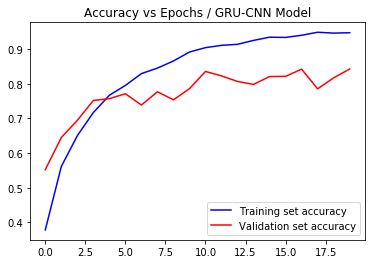

In [4]:
plt.figure()
plt.plot(t_accu, c='b', label='Training set accuracy')
plt.plot(v_accu, c='r', label='Validation set accuracy')
plt.title('Accuracy vs Epochs / GRU-CNN Model')
plt.legend()
plt.show()